In [2]:
import plotly.express as px
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

Loading in data

In [2]:
def extract_xlsx(xlsx_name, ws_name):
  xlsx = pd.ExcelFile(xlsx_name)
  return pd.read_excel(xlsx, ws_name)

In [3]:
wa_race_data = extract_xlsx("Data/OverdoseDeathWA.xlsx", "By Demo-RE")
wa_race_data

,Year,Time Aggregation,Location,Geography,Drug Category,Race,Death Count,Population,Crude Death Rate,Crude Lower CI,Crude Upper CI,Adjusted Death Rate,Adjusted Lower CI,Adjusted Upper CI,Date-Time Stamp
0,2019,1 year rolling counts,Adams County,County,Heroin,Native Hawaiian Pacific Islander*,0,9.0,0,0,29914.5,NaN,NaN,NaN,2023-07-25 08:33:43.039
1,2019,1 year rolling counts,Asotin County,County,Heroin,Native Hawaiian Pacific Islander*,0,56.0,0,0,6419.39,NaN,NaN,NaN,2023-07-25 08:33:43.039
2,2019,1 year rolling counts,Benton County,County,Heroin,Native Hawaiian Pacific Islander*,0,324.0,0,0,1171.74,NaN,NaN,NaN,2023-07-25 08:33:43.039
3,2019,1 year rolling counts,Benton-Franklin,County,Heroin,Native Hawaiian Pacific Islander*,0,463.0,0,0,822.86,NaN,NaN,NaN,2023-07-25 08:33:43.039
4,2019,1 year rolling counts,Chelan County,County,Heroin,Native Hawaiian Pacific Islander*,0,121.0,0,0,3077.07,NaN,NaN,NaN,2023-07-25 08:33:43.039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45355,2022,5 year rolling counts,Statewide,Statewide,Synthetic Opioids,Hispanic,527,5029243.0,10.48,9.62,11.41,11,10.03,12.15,2023-07-25 08:33:43.039
45356,2022,5 year rolling counts,Statewide,Statewide,Synthetic Opioids,Multiple Races*,231,1657488.0,13.94,12.25,15.85,18.07,15.69,20.91,2023-07-25 08:33:43.039
45357,2022,5 year rolling counts,Statewide,Statewide,Synthetic Opioids,Native Hawaiian Pacific Islander*,31,272603.0,11.37,8.01,16.14,10.47,7.04,18.89,2023-07-25 08:33:43.039
45358,2022,5 year rolling counts,Statewide,Statewide,Synthetic Opioids,Unknown,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-07-25 08:33:43.039


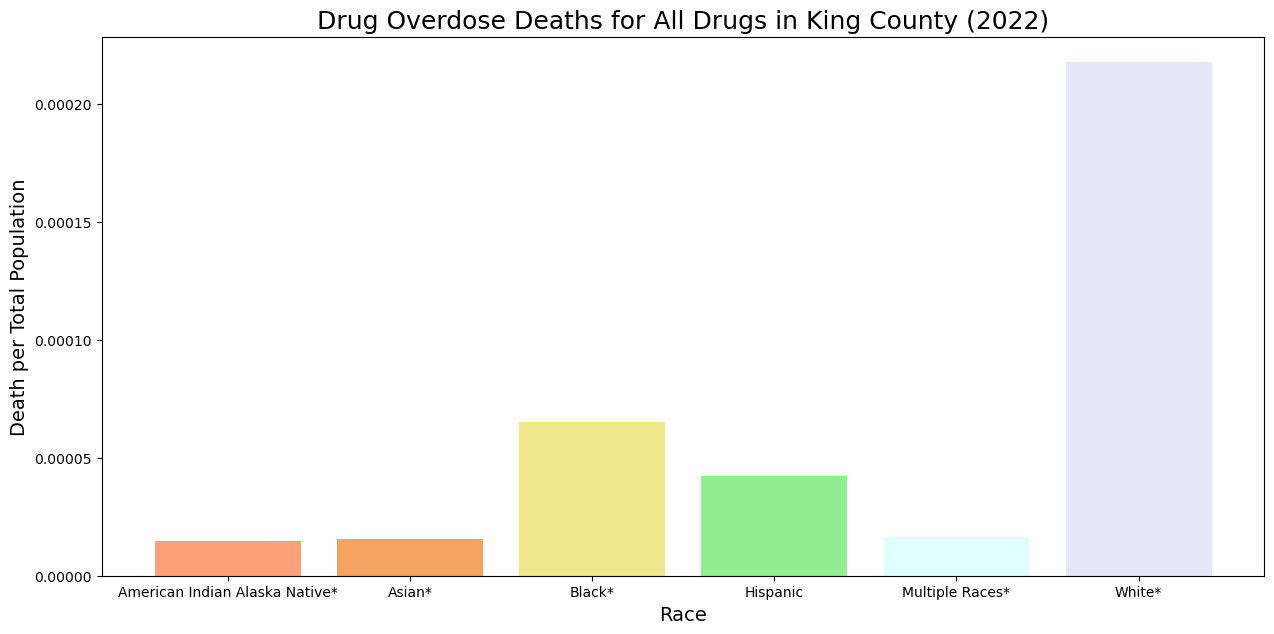

In [4]:
king_county = wa_race_data[['Year', 'Location', 'Drug Category', 'Race',
                            'Time Aggregation', 'Death Count',
                            'Population']].copy()

# Filter data
year = (king_county['Year'] == 2022)
is_king = (king_county['Location'] == 'King County')
drug = (king_county['Drug Category'] == 'Any Drug')
time = (king_county['Time Aggregation'] == '1 year rolling counts')
not_star = (king_county['Death Count']) != '*'

king_county = king_county[year & is_king & drug & time & not_star]
king_county['Death Count'] = king_county['Death Count'].astype(float)

# Normalize to total population
tot_pop = king_county['Population'].sum()
king_county['Death per Capita'] = king_county['Death Count']/tot_pop

# Plot
plt.figure(figsize=(15, 7))
colors = ['lightsalmon', 'sandybrown', 'khaki', 'lightgreen', 'lightcyan', 'lavender']
plt.bar(king_county['Race'], king_county['Death per Capita'], color=colors)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Death per Total Population', fontsize=14)
plt.title('Drug Overdose Deaths for All Drugs in King County (2022)', fontsize=18)
plt.show()
# plt.savefig('wa_race_overdose.png')

In [ ]:
data = {
    'Category': ['A', 'B', 'C', 'D'],
    'Value1': [15, 30, 45, 20],
    'Value2': [25, 10, 35, 45]
}

df = pd.DataFrame(data)

# Using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(df['Category'], df['Value1'], label='Value1')
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Plot with Multiple Categories')
plt.legend()
plt.show()

In [ ]:
def merge_geo(shp_file_name, xlsx_file=None, csv_file_name=None):
    """
    This function takes the name of the shapes file and Excel workbook file OR
    a CSV file and returns a geospatial dataframe that joins these two datasets
    by state.
    """
    shp_file = gpd.read_file(shp_file_name)
    is_mainland = (shp_file['STUSPS'] != 'AK') & \
                  (shp_file['STUSPS'] != 'HI') & \
                  (shp_file['STUSPS'] != 'GU') & \
                  (shp_file['STUSPS'] != 'PR') & \
                  (shp_file['STUSPS'] != 'MP') & \
                  (shp_file['STUSPS'] != 'AS') & \
                  (shp_file['STUSPS'] != 'VI')
    shp_file = shp_file[is_mainland]

    if xlsx_file is None:
        csv_file = pd.read_csv(csv_file_name)
        csv_file = csv_file[
            (csv_file["State Name"] != "Alaska") &
            (csv_file["State Name"] != "Hawaii")
        ]
        merged_data = shp_file.merge(csv_file, left_on='STUSPS',
                                     right_on='State', how='outer')
    else:
        merged_data = shp_file.merge(xlsx_file, left_on="NAMELSAD",
                                     right_on="Location")
    return merged_data

Defining names for datasets

In [ ]:
xlsx_file = extract_xlsx('Data/OverdoseDeathWA.xlsx', 'By Location and Date')
wa_geo_data = merge_geo("Data/geodata/cb_2022_us_county_500k.shp", xlsx_file)
national_geo_data = merge_geo("Data/geodata/cb_2022_us_county_500k.shp", csv_file_name="Data/NationalOverdose.csv")

(1) How has the number of drug overdose cases changed between 2015 and 2023 in Washington State?

In [ ]:
def wa_overdose_change(wa_data:  pd.ExcelFile,
                       start: float = 2016.0,
                       end: float = 2022.0) -> None:
    """
    This function takes in the geospatial dataframe and returns the number
    of drug overdose cases in Washington from 2016-2023.
    """
    geography = wa_data["Geography"] == 'County'
    drug = wa_data["Drug Category"] == "Any Drug"
    year = (wa_data["Year"] >= start) & (wa_data["Year"] <= end)
    time = wa_data["Time Aggregation"] == "1 year rolling counts"
    remove_star = wa_data["Death Count"] != "*"
    county_data = wa_data[geography & drug & time & year & remove_star].copy()
    county_data["Death Count"] = county_data["Death Count"].astype("int")
    county_data = \
        county_data.groupby("Year").agg({"Death Count": "sum"}).reset_index()

    fig = px.line(
        county_data,
        x="Year",
        y="Death Count",
        title=f"Drug Overdose Deaths in WA between "
        f"{int(start)} and {int(end)}",
        markers=True
    )
    fig.update_layout(title_x=0.5, title_y=0.95, font=dict(size=15))
    fig.update_traces(line=dict(width=4), marker=dict(size=10))
    # fig.write_image('wa_overdose.png')
    fig.show()

In [ ]:
wa_overdose_change(wa_geo_data)

In [ ]:
def test_wa_overdose_change(data, start=2016.0, end=2022.0) -> pd.DataFrame:
    """
    This function takes in the geospatial dataframe and returns the number
    of drug overdose cases in Washington from 2016-2023.
    """
    wa_data = data[data["STATE_NAME"] == "Washington"].copy()
    drug = wa_data["Drug Category"] == "Any Drug"
    county = wa_data["Geography"] == "County"
    wa_data["Year"] = pd.to_numeric(data["Year"], errors="coerce")
    year = (wa_data["Year"] >= start) & (wa_data["Year"] <= end)
    time = wa_data["Time Aggregation"] == "1 year rolling counts"
    remove_star = wa_data["Death Count"] != "*"
    county_data = wa_data[drug & county & time & year & remove_star].copy()
    county_data["Death Count"] = county_data["Death Count"].astype("int")
    county_data = \
        county_data.groupby("Year").agg({"Death Count": "sum"}).reset_index()
    
    print('Printing table of death counts in Washington 2016-2022:')
    print()
    print(county_data)

In [ ]:
test_wa_overdose_change(wa_geo_data)

(2) Which counties in Washington state have the highest number/rate of drug overdose cases?

In [ ]:
def overdose_deaths_counties(data: gpd.GeoDataFrame, drug_name='Any Drug',
                             year_start=2016.0, year_end=2022.0) -> None:
    """
    This function takes in the geospatial dataframe and plots the drug
    overdose cases in different counties in Washington.
    """
    data = data[data['STATE_NAME'] == 'Washington'].copy()
    drug = data['Drug Category'] == drug_name
    county = data['Geography'] == 'County'
    time = (data['Time Aggregation'] == '1 year rolling counts')
    remove_star = data['Death Count'] != '*'
    county_data = data[drug & county & time & remove_star].copy()
    county_data['Death Count'] = county_data['Death Count'].astype('int')

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Washington County Overdose Deaths", fontsize=18, y=0.95)
    n = int(year_end - year_start)
    height, width = n // 2 + 1, 2
    for i in range(int(year_start), int(year_end)+1):
        year = (county_data['Year'] == i)
        year_data = county_data[year]

        ax = plt.subplot(height, width, i - int(year_start)+1)

        data.plot(ax=ax, color='#d3d3d3')
        year_data.plot(ax=ax, column='Death Count', legend=True)
        ax.set_title(i)
        ax.set_aspect('equal')
    plt.savefig('counties_overdose.png')

In [ ]:
overdose_deaths_counties(wa_geo_data)

(3) How does the number of overdoses in WA compare to number of overdoses in other states in the USA?

In [3]:
shape = gpd.read_file('Data/geodata/cb_2022_us_county_500k.shp')
shape

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,geometry
0,01,069,00161560,0500000US01069,01069,Houston,Houston County,AL,Alabama,06,1501742235,4795415,"POLYGON ((-85.71209 31.19727, -85.70934 31.198..."
1,01,023,00161537,0500000US01023,01023,Choctaw,Choctaw County,AL,Alabama,06,2365900083,19114321,"POLYGON ((-88.47323 31.89386, -88.46888 31.930..."
2,01,005,00161528,0500000US01005,01005,Barbour,Barbour County,AL,Alabama,06,2292160151,50523213,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,01,107,00161580,0500000US01107,01107,Pickens,Pickens County,AL,Alabama,06,2282835044,22621093,"POLYGON ((-88.34043 32.99120, -88.33101 33.072..."
4,01,033,00161542,0500000US01033,01033,Colbert,Colbert County,AL,Alabama,06,1535742270,79160396,"POLYGON ((-88.13925 34.58779, -88.13872 34.589..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3230,20,197,00485059,0500000US20197,20197,Wabaunsee,Wabaunsee County,KS,Kansas,06,2057320864,13845234,"POLYGON ((-96.50168 38.91332, -96.50166 38.927..."
3231,21,211,00516952,0500000US21211,21211,Shelby,Shelby County,KY,Kentucky,06,983652108,15210913,"POLYGON ((-85.46821 38.28531, -85.46073 38.285..."
3232,27,093,00659492,0500000US27093,27093,Meeker,Meeker County,MN,Minnesota,06,1574629006,94913846,"POLYGON ((-94.76346 45.24619, -94.76334 45.275..."
3233,39,015,01074020,0500000US39015,39015,Brown,Brown County,OH,Ohio,06,1267911780,8879057,"POLYGON ((-84.05245 38.77223, -84.04800 38.806..."


In [ ]:
is_mainland = (shape['STUSPS'] != 'AK') & (shape['STUSPS'] != 'HI') & (shape['STUSPS'] != 'GU') & (shape['STUSPS'] != 'PR') & (shape['STUSPS'] != 'MP') & (shape['STUSPS'] != 'AS') & (shape['STUSPS'] != 'VI')
shape = shape[is_mainland]

In [ ]:
shape['STUSPS'].unique()